In [1]:
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf

from collections import Counter
from pathlib import Path
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

# ELEC0135 Assignment

## Introduction

Based on the competition here: https://www.kaggle.com/competitions/cassava-leaf-disease-classification

## Source Data

As this is an exploratory Kaggle notebook, I've just loaded in the hosted `cassava-leaf-diesease-classification` dataset in here.  The final script will need some data loading logic, so that it can be submitted for testing/marking purposes.

In [2]:
SOURCE_DATA = Path("/kaggle/input/cassava-leaf-disease-classification/")

WORKING_DATA = Path("/kaggle/working/data/elec0135-assignment-cld/")
WORKING_DATA.mkdir(parents=True, exist_ok=True)

# Parameters
IMAGE_SIZE = 120
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.25
EPOCHS = 50
ES = True
ES_PATIENCE = 10

## EDA

### What are we looking at?

In [3]:
with open(SOURCE_DATA / "label_num_to_disease_map.json", "r") as label_file:
    print(json.dumps(json.load(label_file),indent=2))

{
  "0": "Cassava Bacterial Blight (CBB)",
  "1": "Cassava Brown Streak Disease (CBSD)",
  "2": "Cassava Green Mottle (CGM)",
  "3": "Cassava Mosaic Disease (CMD)",
  "4": "Healthy"
}


### Class Balance

In [4]:
df_train = pd.read_csv(SOURCE_DATA / "train.csv")
df_train.groupby(['label']).count()

,image_id
label,
0,1087
1,2189
2,2386
3,13158
4,2577


There's a large class imbalance here for `0` (CBB), which will need taking into account during the training.  Initial thoughts are that this will be especially true if I end up using a binary-classification gate in a `Mixture of Experts` model.

### Some Sample Images

In [5]:
def get_image_path(image_id: str) -> Path:
    return SOURCE_DATA / "train_images" / image_id

In [6]:
im = Image.open(get_image_path(df_train.loc[0, "image_id"]))
print(im.size)

(800, 600)


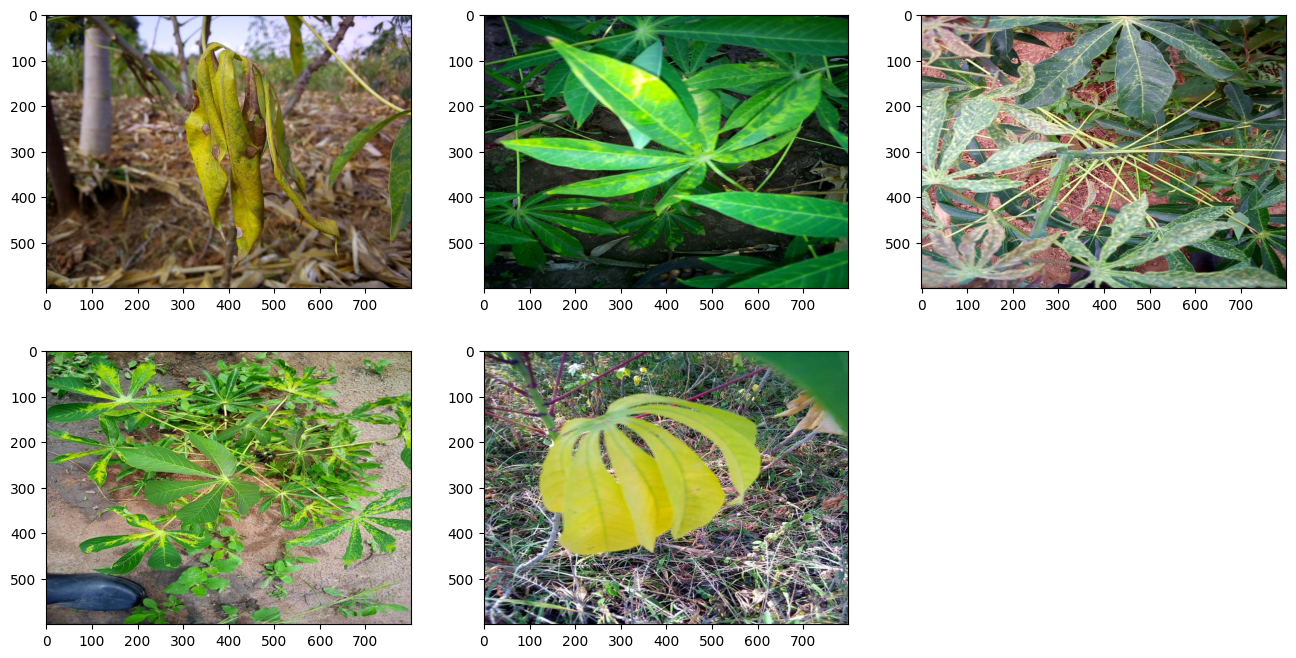

In [7]:
df_single_sample = df_train.groupby('label').apply(lambda x: x.sample(1), include_groups = False).reset_index()

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
plt.axis('off')

for index, row in df_single_sample.iterrows():
    lab = row["label"]
    image_id = row["image_id"]
    a = plt.imread(get_image_path(image_id))
    axs[int(index/3), index%3].imshow(a)

There's high variability in the images - some closer shots, some further away etc.

## Data Processing

With only ~1000 instances of label/class `0`, my first thought is that some data augmentation is going to be required here.  I'm going to hold off with that first and see how a basic VGG-style network, such as that explored in the labs, fares.

Ideas:

* Data Augmentation
* For the assignment, shrink the images to make the data aspect more manageable
* Train on full (unbalanced) dataset
* Train on balanced (smaller) dataset

In [8]:
def create_equal_split_dataset(df_map: pd.DataFrame) -> Path:
    es_path = WORKING_DATA / "equal_split"
    es_path.mkdir(parents=True, exist_ok=True)
    
    for lab in df_map.label.unique():
        (es_path / str(lab)).mkdir(exist_ok=True)
        
    source_path = SOURCE_DATA / "train_images"
    
    # take n first items from each class
    df_map['counter'] = 1
    df_map['class_count'] = df_map[['label', 'counter']].groupby(['label']).cumsum()
    
    for index, row in df_map.iterrows():
        lab = row["label"]
        image_id = row["image_id"]
        img = source_path / image_id
        dest = es_path / str(lab) / image_id

        class_count = row["class_count"]
        if class_count > 1087:
            continue
        shutil.copyfile(img, dest)
        
    return es_path


def get_equal_split_dataset(path: Path):
    # Load dataset
    # categorical here means that the labels are one-hot encoded
    ds_train_, ds_valid_ = image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[IMAGE_SIZE, IMAGE_SIZE],
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=VALIDATION_SPLIT,
        subset="both",
        seed=31415,
    )   

    # Data Pipeline
    def convert_to_float(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = image / 255.0
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    return ds_train, ds_valid


def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = EPOCHS) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = EPOCHS) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

In [9]:
# need to add some optimisation here to avoid re-create files if already exist
dataset_path = create_equal_split_dataset(df_train)

In [10]:
ds_train, ds_valid = get_equal_split_dataset(dataset_path)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.


## Model

Create a baseline first using a very simple model, such as that seen in the labs.  How well does it do with the limited / equal weight split?

Random model / baseline would be 20% (since five classes of equal weight).

In [11]:
# df_experiment = pd.DataFrame(columns=["exp_id", "desc", "batch_size", "img_width", "img_height", "model"])
# df_history = pd.DataFrame(columns=["loss", "accuracy", "val_loss", "val_accuracy"])

In [13]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [14]:
def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str, ds_train_, ds_valid_):
    
    #data = {"exp_id":"1", "desc":"something", "batch_size":BATCH_SIZE, "img_width":0, "img_height":0, "model": model_str}
    #df_experiment = pd.concat([pd.DataFrame([data]), df_experiment])
    
    model = model_fn()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=ES_PATIENCE,
        restore_best_weights=True,
    )
    
    cbs = []
    if ES:
        print("Using EarlyStopping")
        cbs += [early_stopping]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=EPOCHS,
        verbose=1,
        callbacks=cbs
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist


def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])

In [15]:
df_results = pd.DataFrame

In [17]:
# set early stopping to false just to get a full look at the training
ES = False

# starting point for the batch-size
BATCH_SIZE = 64
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("1", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50


I0000 00:00:1708812057.737149     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 20s 143ms/step - loss: 1.6097 - accuracy: 0.1886 - val_loss: 1.6088 - val_accuracy: 0.2158
Epoch 2/50
64/64 [==============================] - 4s 59ms/step - loss: 1.6091 - accuracy: 0.1979 - val_loss: 1.6081 - val_accuracy: 0.2209
Epoch 3/50
64/64 [==============================] - 4s 59ms/step - loss: 1.6069 - accuracy: 0.2178 - val_loss: 1.6049 - val_accuracy: 0.2231
Epoch 4/50
64/64 [==============================] - 4s 59ms/step - loss: 1.5974 - accuracy: 0.2249 - val_loss: 1.5809 - val_accuracy: 0.2857
Epoch 5/50
64/64 [==============================] - 4s 59ms/step - loss: 1.5983 - accuracy: 0.2296 - val_loss: 1.5847 - val_accuracy: 0.2872
Epoch 6/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5579 - accuracy: 0.2806 - val_loss: 1.5641 - val_accuracy: 0.2776
Epoch 7/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5549 - accuracy: 0.2575 - val_loss: 1.4960 - val_accuracy: 0.3004
Epoch 8/50
64/64 [====

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

<Axes: xlabel='epoch', ylabel='val_loss'>

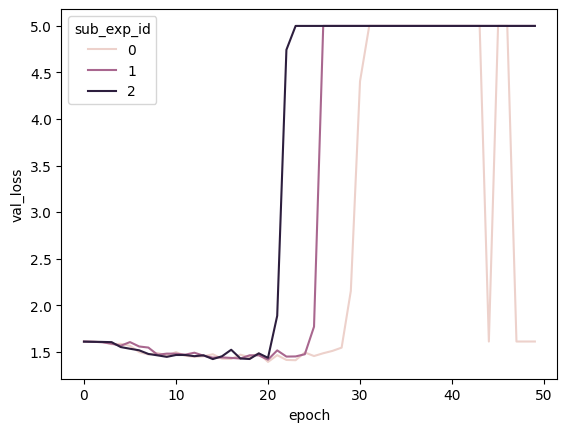

In [26]:
sns.lineplot(data=df_results2[df_results2.exp_id=="1"], x="epoch", y="val_loss", hue="sub_exp_id")

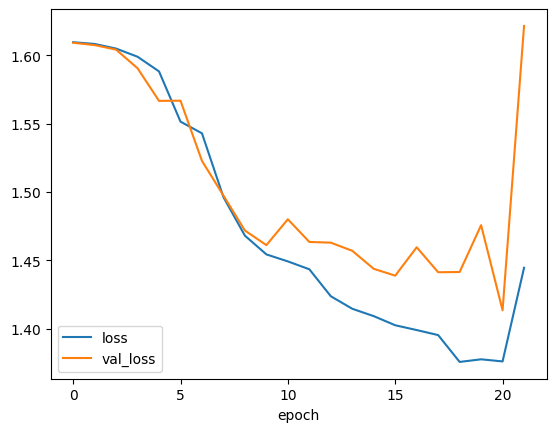

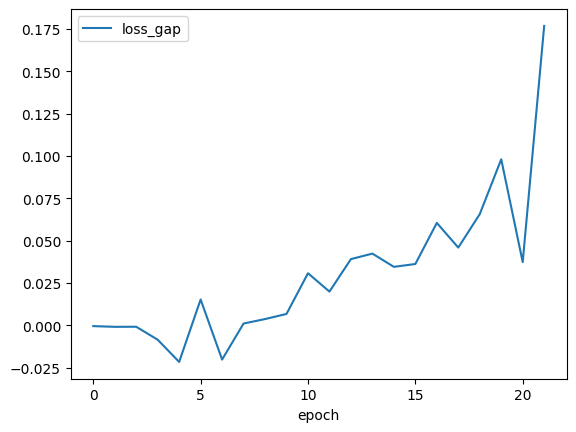

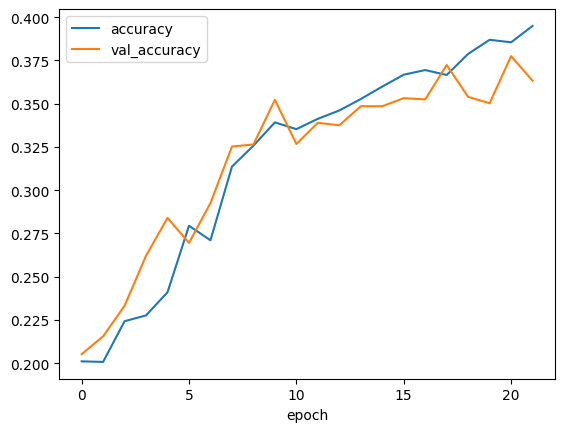

In [42]:
plot_experiment_results(df_results, "1", 21)

In [43]:
ES = False
BATCH_SIZE = 128
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("2", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50
32/32 [==============================] - 21s 346ms/step - loss: 1.6095 - accuracy: 0.2060 - val_loss: 1.6091 - val_accuracy: 0.2003
Epoch 2/50
32/32 [==============================] - 3s 106ms/step - loss: 1.6085 - accuracy: 0.2021 - val_loss: 1.6082 - val_accuracy: 0.1856
Epoch 3/50
32/32 [==============================] - 3s 107ms/step - loss: 1.6074 - accuracy: 0.2127 - val_loss: 1.6059 - val_accuracy: 0.2032
Epoch 4/50
32/32 [==============================] - 3s 106ms/step - loss: 1.6045 - accuracy: 0.2185 - val_loss: 1.5998 - val_accuracy: 0.2401
Epoch 5/50
32/32 [==============================] - 3s 106ms/step - loss: 1.5973 - accuracy: 0.2534 - val_loss: 1.5901 - val_accuracy: 0.2415
Epoch 6/50
32/32 [==============================] - 3s 107ms/step - loss: 1.5792 - accuracy: 0.2578 - val_loss: 1.5630 - val_accuracy: 0.2467
Epoch 7/50
32/32 [========================

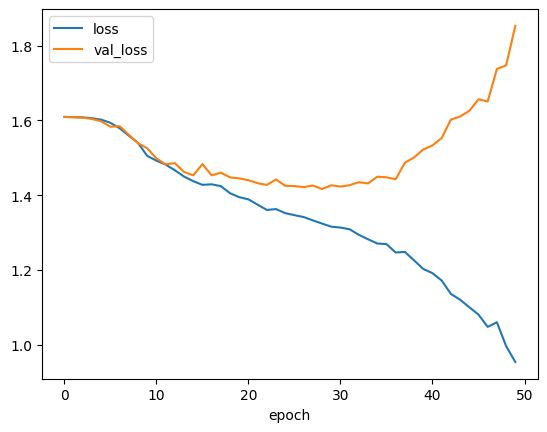

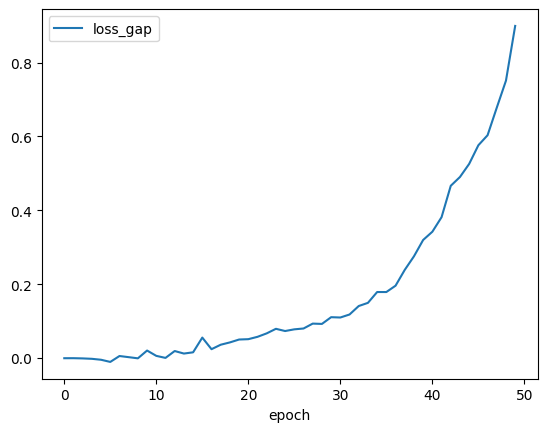

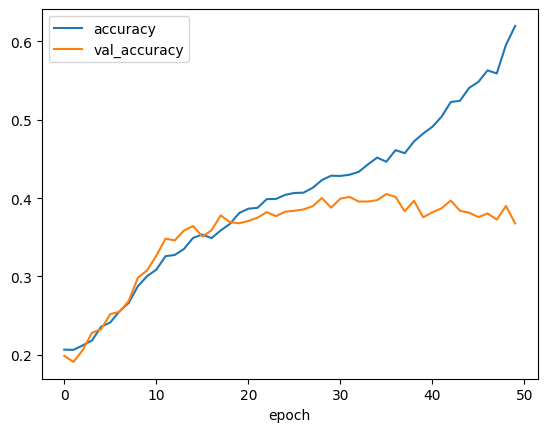

In [44]:
plot_experiment_results(df_results, "2")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

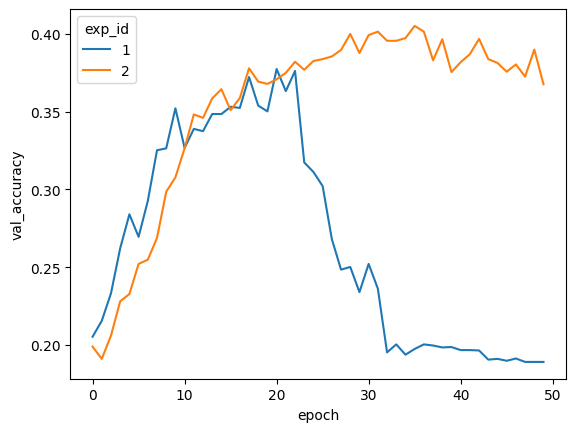

In [66]:
plot_experiments_comp(df_results, ["1","2"])

In [67]:
ES = False
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("3", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50
21/21 [==============================] - 26s 655ms/step - loss: 1.6097 - accuracy: 0.2063 - val_loss: 1.6092 - val_accuracy: 0.2054
Epoch 2/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6098 - accuracy: 0.1938 - val_loss: 1.6090 - val_accuracy: 0.2135
Epoch 3/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6087 - accuracy: 0.1979 - val_loss: 1.6083 - val_accuracy: 0.2121
Epoch 4/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6081 - accuracy: 0.2070 - val_loss: 1.6072 - val_accuracy: 0.2187
Epoch 5/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6065 - accuracy: 0.2181 - val_loss: 1.6060 - val_accuracy: 0.2106
Epoch 6/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6054 - accuracy: 0.2190 - val_loss: 1.6032 - val_accuracy: 0.2224
Epoch 7/50
21/21 [========================

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

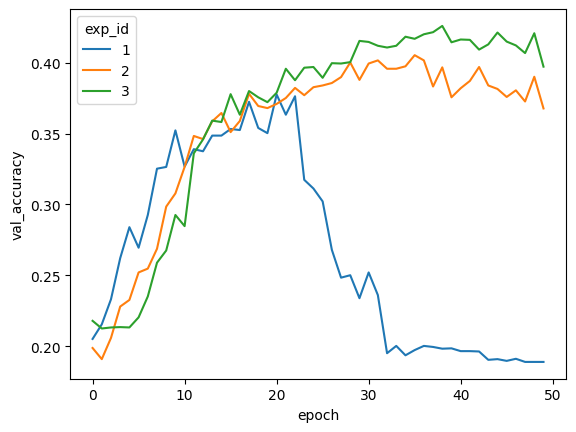

In [73]:
plot_experiments_comp(df_results, ["1","2", "3"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

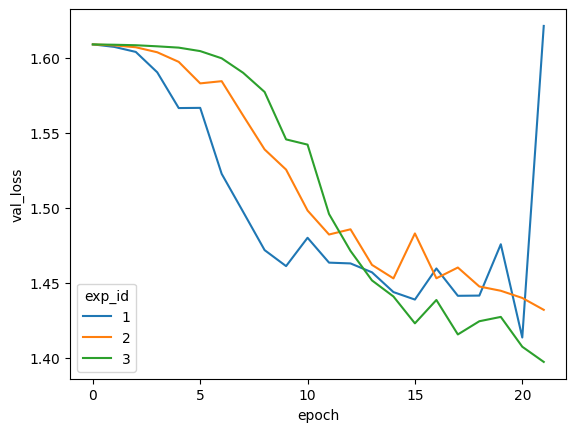

In [77]:
plot_experiments_comp(df_results, ["1","2", "3"], "val_loss", 21)

In [78]:
ES = False
BATCH_SIZE = 256
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("4", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50
16/16 [==============================] - 28s 837ms/step - loss: 1.6090 - accuracy: 0.1918 - val_loss: 1.6090 - val_accuracy: 0.1996
Epoch 2/50
16/16 [==============================] - 3s 200ms/step - loss: 1.6087 - accuracy: 0.2129 - val_loss: 1.6089 - val_accuracy: 0.1996
Epoch 3/50
16/16 [==============================] - 3s 200ms/step - loss: 1.6090 - accuracy: 0.1940 - val_loss: 1.6088 - val_accuracy: 0.1996
Epoch 4/50
16/16 [==============================] - 3s 200ms/step - loss: 1.6086 - accuracy: 0.2124 - val_loss: 1.6085 - val_accuracy: 0.2172
Epoch 5/50
16/16 [==============================] - 3s 200ms/step - loss: 1.6080 - accuracy: 0.2117 - val_loss: 1.6081 - val_accuracy: 0.2121
Epoch 6/50
16/16 [==============================] - 3s 200ms/step - loss: 1.6066 - accuracy: 0.2308 - val_loss: 1.6077 - val_accuracy: 0.2239
Epoch 7/50
16/16 [========================

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

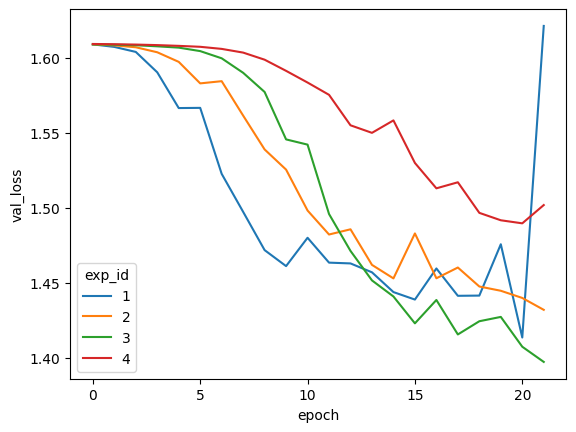

In [79]:
plot_experiments_comp(df_results, ["1","2","3","4"], "val_loss", 21)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

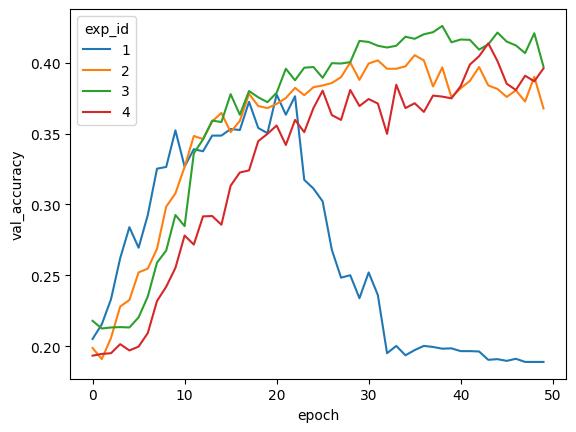

In [80]:
plot_experiments_comp(df_results, ["1","2","3","4"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

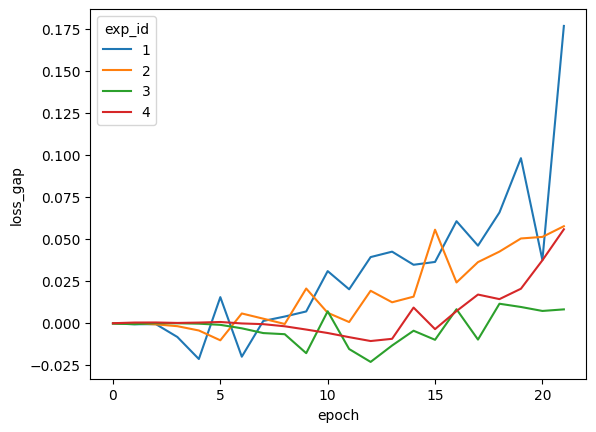

In [83]:
plot_experiments_comp(df_results, ["1","2","3","4"], "loss_gap", 21)

In [81]:
df_results.to_csv(WORKING_DATA / "results.csv")

Batch size of between 196-256 seems optimal, certainly moreso than 64, whereas the model descends into a very bad state from epoch 20 onwards.  Using a batch size of 196 should give a good baseline against which to experiment further.

### Baseline Model

In [16]:
df_results = pd.DataFrame

In [17]:
ES = True
BATCH_SIZE = 196
ds_train, ds_valid = get_equal_split_dataset(dataset_path)
(m, df_hist) = run_experiment("10", 1, create_simple_model, ds_train, ds_valid)
df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


I0000 00:00:1708899719.890066     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


21/21 [==============================] - 29s 623ms/step - loss: 1.6100 - accuracy: 0.1994 - val_loss: 1.6091 - val_accuracy: 0.2135
Epoch 2/50
21/21 [==============================] - 3s 158ms/step - loss: 1.6094 - accuracy: 0.2009 - val_loss: 1.6091 - val_accuracy: 0.2297
Epoch 3/50
21/21 [==============================] - 3s 160ms/step - loss: 1.6083 - accuracy: 0.2124 - val_loss: 1.6088 - val_accuracy: 0.2239
Epoch 4/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6087 - accuracy: 0.2048 - val_loss: 1.6084 - val_accuracy: 0.2047
Epoch 5/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6076 - accuracy: 0.2124 - val_loss: 1.6079 - val_accuracy: 0.2297
Epoch 6/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6075 - accuracy: 0.2156 - val_loss: 1.6069 - val_accuracy: 0.1996
Epoch 7/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6073 - accuracy: 0.2141 - val_loss: 1.6052 - val_accuracy: 0.2518
Epoch 8/50
21/21

In [18]:
m.evaluate(ds_valid)

7/7 [==============================] - 0s 45ms/step - loss: 1.4452 - accuracy: 0.4102


[1.445219874382019, 0.4101620018482208]

In [19]:
probabilities = m.predict(ds_valid)
predictions = np.argmax(probabilities, axis=-1)
Counter(predictions)

7/7 [==============================] - 0s 43ms/step


Counter({3: 513, 0: 312, 4: 266, 1: 172, 2: 95})

In [20]:
print(len(probabilities))
print(probabilities[0])
print(predictions[0])
print(probabilities[1])
print(predictions[1])

1358
[0.30483028 0.22700289 0.12055612 0.01444934 0.33316132]
4
[0.01490044 0.00898642 0.1619153  0.7519553  0.06224259]
3


In [42]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [43]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("11", i, create_simple_model_bn, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 12s 239ms/step - loss: 1.6050 - accuracy: 0.2308 - val_loss: 1.6085 - val_accuracy: 0.2040
Epoch 2/50
21/21 [==============================] - 3s 160ms/step - loss: 1.5623 - accuracy: 0.2860 - val_loss: 1.6046 - val_accuracy: 0.2084
Epoch 3/50
21/21 [==============================] - 3s 160ms/step - loss: 1.5028 - accuracy: 0.3196 - val_loss: 1.5987 - val_accuracy: 0.2747
Epoch 4/50
21/21 [==============================] - 3s 160ms/step - loss: 1.4700 - accuracy: 0.3392 - val_loss: 1.5915 - val_accuracy: 0.3034
Epoch 5/50
21/21 [==============================] - 3s 159ms/step - loss: 1.4303 - accuracy: 0.3610 - val_loss: 1.5863 - val_accuracy: 0.3027
Epoch 6/50
21/21 [==============================] - 3s 158ms/step - loss: 1.4166 - accuracy: 0.3696 - val_loss: 1.5885 - val_accuracy: 0.2187
Epoch 7/50
21/21 [====

In [21]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn2() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [22]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("12", i, create_simple_model_bn2, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 12s 258ms/step - loss: 1.6111 - accuracy: 0.2048 - val_loss: 1.6093 - val_accuracy: 0.2018
Epoch 2/50
21/21 [==============================] - 4s 173ms/step - loss: 1.6084 - accuracy: 0.2068 - val_loss: 1.6086 - val_accuracy: 0.2327
Epoch 3/50
21/21 [==============================] - 4s 173ms/step - loss: 1.6023 - accuracy: 0.2433 - val_loss: 1.6056 - val_accuracy: 0.2452
Epoch 4/50
21/21 [==============================] - 4s 173ms/step - loss: 1.5860 - accuracy: 0.2548 - val_loss: 1.5896 - val_accuracy: 0.2761
Epoch 5/50
21/21 [==============================] - 4s 173ms/step - loss: 1.5385 - accuracy: 0.2862 - val_loss: 1.5569 - val_accuracy: 0.2842
Epoch 6/50
21/21 [==============================] - 4s 173ms/step - loss: 1.5199 - accuracy: 0.3000 - val_loss: 1.5466 - val_accuracy: 0.2761
Epoch 7/50
21/21 [====

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

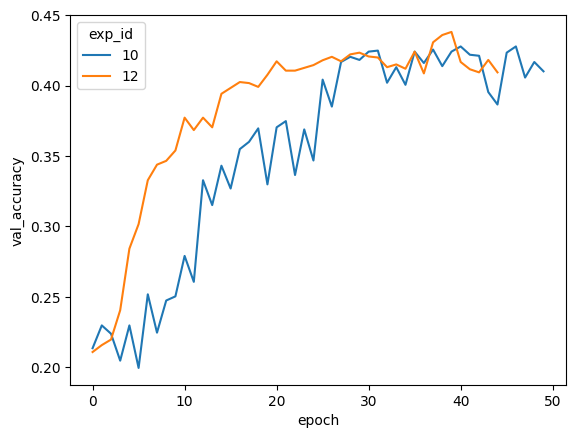

In [25]:
plot_experiments_comp(df_results, ["10","12"], "val_accuracy")

In [28]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("13", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 11s 256ms/step - loss: 1.6096 - accuracy: 0.2095 - val_loss: 1.6093 - val_accuracy: 0.1937
Epoch 2/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6095 - accuracy: 0.1918 - val_loss: 1.6092 - val_accuracy: 0.1885
Epoch 3/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6085 - accuracy: 0.2149 - val_loss: 1.6089 - val_accuracy: 0.2025
Epoch 4/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6084 - accuracy: 0.2107 - val_loss: 1.6084 - val_accuracy: 0.1885
Epoch 5/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6072 - accuracy: 0.2220 - val_loss: 1.6076 - val_accuracy: 0.1944
Epoch 6/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6060 - accuracy: 0.2261 - val_loss: 1.6061 - val_accuracy: 0.2224
Epoch 7/50
21/21 [====

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

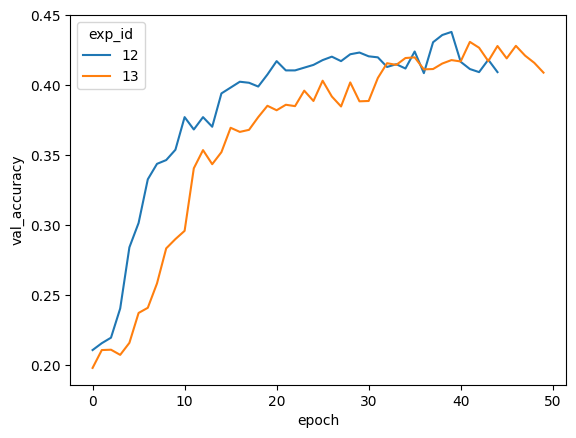

In [31]:
plot_experiments_comp(df_results, ["13","12"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

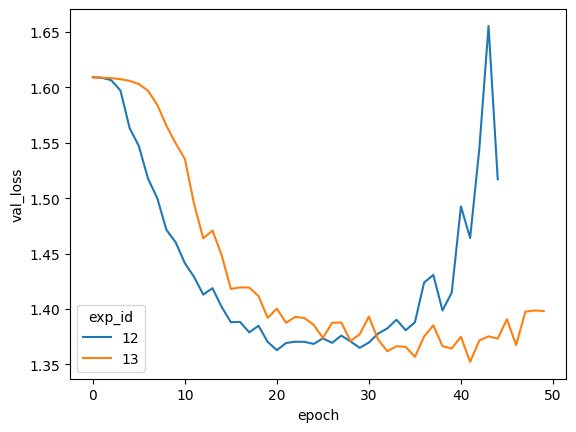

In [32]:
plot_experiments_comp(df_results, ["13","12"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

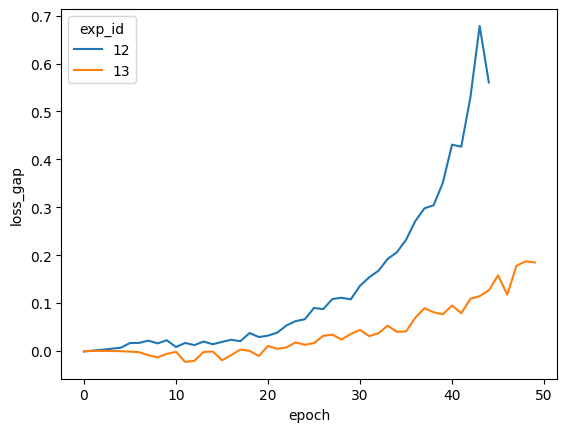

In [33]:
plot_experiments_comp(df_results, ["13","12"], "loss_gap")

Useful links found so far:
    
https://keras.io/api/data_loading/image/

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

https://keras.io/api/applications/vgg/

https://keras.io/api/applications/mobilenet/#mobilenetv2-function

https://keras.io/api/models/model_training_apis/

https://stackoverflow.com/questions/66715975/class-weights-in-cnn

https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting